# OGGM - data pulling

Adds topographical variables from OGGM to the PMB data.

## Setting up:

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import pyproj
import salem
from tqdm.notebook import tqdm
import logging
import matplotlib.pyplot as plt
from oggm import utils, workflow, tasks
from oggm import cfg as oggmCfg
import os
import re
import seaborn as sns
import math
from os.path import isfile, join, isdir
from shapely.geometry import Point

oggmCfg.initialize(logging_level='WARNING')
oggmCfg.PARAMS['border'] = 10
oggmCfg.PARAMS['use_multiprocessing'] = True
oggmCfg.PARAMS['continue_on_error'] = True
# Module logger
log = logging.getLogger('.'.join(__name__.split('.')[:-1]))

2025-04-07 14:30:52: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2025-04-07 14:30:52: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2025-04-07 14:30:52: oggm.cfg: Multiprocessing: using all available processors (N=32)
2025-04-07 14:30:52: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2025-04-07 14:30:52: oggm.cfg: Multiprocessing switched ON after user settings.
2025-04-07 14:30:52: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.


In [ ]:
def emptyfolder(path):
    if os.path.exists(path):
        # Loop through all items in the directory
        for item in os.listdir(path):
            item_path = join(path, item)
            if isfile(item_path):
                os.remove(item_path)  # Remove file
            elif isdir(item_path):
                emptyfolder(item_path)  # Recursively empty the folder
                os.rmdir(item_path)  # Remove the now-empty folder
    else:
        createPath(path)


def createPath(path):
    os.makedirs(path, exist_ok=True)

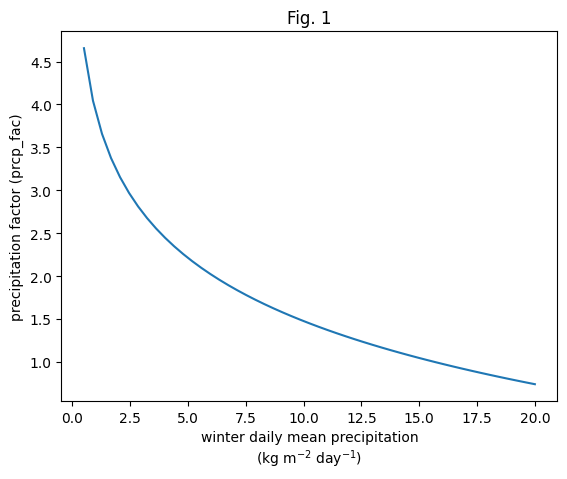

In [2]:
w_prcp_array = np.linspace(0.5, 20, 51)
# we basically do here the same as in massbalance.decide_winter_precip_factor(gdir)
a, b = oggmCfg.PARAMS['winter_prcp_fac_ab']
r0, r1 = oggmCfg.PARAMS['prcp_fac_min'], oggmCfg.PARAMS['prcp_fac_max']
prcp_fac = a * np.log(w_prcp_array) + b
# don't allow extremely low/high prcp. factors!!!
prcp_fac_array = utils.clip_array(prcp_fac, r0, r1)
plt.plot(w_prcp_array, prcp_fac_array)
plt.xlabel(r'winter daily mean precipitation' + '\n' +
           r'(kg m$^{-2}$ day$^{-1}$)')
plt.ylabel('precipitation factor (prcp_fac)')
plt.title('Fig. 1')

# save arrays
np.save('w_prcp_array.npy', w_prcp_array)
np.save('prcp_fac_array.npy', prcp_fac_array)

## Download OGGM data:

In [ ]:
# set working directory
working_dir = '/home/mburlet/DATA_MBM/OGGM/'
oggmCfg.PATHS['working_dir'] = working_dir

# Set RGI version and region:
rgi_region = "11"  # Central Europe
rgi_version = "6"
rgi_dir = utils.get_rgi_dir(version=rgi_version)

In [ ]:
path = utils.get_rgi_region_file(region=rgi_region, version=rgi_version)
rgidf = gpd.read_file(path)

# We use the directories with the shop data in it: "W5E5_w_data"
base_url = "https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5_w_data/"
gdirs = workflow.init_glacier_directories(
    rgidf,
    from_prepro_level=3,
    prepro_base_url=base_url,
    prepro_border=10,
    reset=True,
    force=True,
)

# Tested tasks
task_list = [
    tasks.gridded_attributes,
    # tasks.gridded_mb_attributes,
    # get_gridded_features,
]
for task in task_list:
    workflow.execute_entity_task(task, gdirs, print_log=False)
    
    # save OGGM xr for all needed glaciers: 
emptyfolder('/home/mburlet/DATA_MBM/OGGM/xr_grids/')
for gdir in tqdm(gdirs):
    RGIId = gdir.rgi_id
    with xr.open_dataset(gdir.get_filepath("gridded_data")) as ds:
        ds = ds.load()
        
    # save ds
    ds.to_netcdf(f'/home/mburlet/DATA_MBM/OGGM/xr_grids/{RGIId}.nc')

## Load PMB data:

In [ ]:
# Load PMB data:
path_PMB_GLAMOS_csv = '/home/mburlet/DATA_MBM/GLAMOS/point/csv/'
df_pmb = pd.read_csv(path_PMB_GLAMOS_csv + f'df_pmb_all.csv')

print('Number of winter and annual samples:', len(df_pmb))
print('Number of annual samples:',
      len(df_pmb[df_pmb.PERIOD == 'annual']))
print('Number of winter samples:',
      len(df_pmb[df_pmb.PERIOD == 'winter']))

# Get OGGM info of one sample:
RGI = df_pmb.iloc[0].RGIId
# Get oggm data for that RGI ID
for gdir in gdirs:
    if gdir.rgi_id == RGI:
        break
with xr.open_dataset(gdir.get_filepath("gridded_data")) as ds:
    ds = ds.load()
ds

## Merge with OGGM data:

In [ ]:
# load shapefiles
# Load RGI shapefile for the specified region and version
path = utils.get_rgi_region_file(region=rgi_region, version=rgi_version)
rgidf = gpd.read_file(path)

# All possible variables of interest from oggm
# voi = [
#     "aspect", "slope", "dis_from_border", "topo", "hugonnet_dhdt",
#     "consensus_ice_thickness", "millan_ice_thickness", "millan_v", "millan_vx",
#     "millan_vy"
# ]

voi = [
    "aspect",
    "slope",
    "topo",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
]

# Initialise empty:
for var in voi:
    df_pmb[var] = np.nan
   
df_pmb['within_glacier_shape'] = False
    
grouped = df_pmb.groupby("RGIId")

# Process each group
for rgi_id, group in grouped:
    # Get oggm data for that RGI ID
    for gdir in gdirs:
        if gdir.rgi_id == rgi_id:
            break

    with xr.open_dataset(gdir.get_filepath("gridded_data")) as ds:
        ds = ds.load()
        
    # Find the specific shape for the current RGI ID
    glacier_shape = rgidf[rgidf["RGIId"] == rgi_id]
    if glacier_shape.empty:
        print(f"Warning: No shape found for RGIId {rgi_id}, skipping...")
        continue

    # Define the coordinate transformation
    transf = pyproj.Transformer.from_proj(
        pyproj.CRS.from_user_input("EPSG:4326"),  # Input CRS (WGS84)
        pyproj.CRS.from_user_input(ds.pyproj_srs),  # Output CRS from dataset
        always_xy=True
    )
    
    # Transform all coordinates in the group
    lon, lat = group["POINT_LON"].values, group["POINT_LAT"].values
    x_stake, y_stake = transf.transform(lon, lat)
    
    # Create a GeoDataFrame for df_pmb points
    geometry = [Point(xy) for xy in zip(group["POINT_LON"], group["POINT_LAT"])]
    points_rgi = gpd.GeoDataFrame(group, geometry=geometry, crs="EPSG:4326")

    # Filter points that intersect with this specific shape
    glacier_shape = glacier_shape.to_crs(points_rgi.crs)  # Ensure CRS matches
    points_in_glacier = gpd.sjoin(points_rgi.loc[group.index], glacier_shape, predicate="within", how="inner")
            
    # Select nearest values for all points
    stake = ds.sel(
        x=xr.DataArray(x_stake, dims="points"),
        y=xr.DataArray(y_stake, dims="points"),
        method="nearest"
    )

    # Extract variables of interest
    stake_var = stake[voi]

    # Convert the extracted data to a DataFrame
    stake_var_df = stake_var.to_dataframe()

    # Update the DataFrame with the extracted values
    for var in voi:
        df_pmb.loc[group.index, var] = stake_var_df[var].values
    
    df_pmb.loc[points_in_glacier.index, 'within_glacier_shape'] = True
    
# change from radians to degrees so that it agrees with sgi data
df_pmb['aspect'] = df_pmb['aspect'].apply(lambda x: math.degrees(x))
df_pmb['slope'] = df_pmb['slope'].apply(lambda x: math.degrees(x))

In [ ]:
# Example:
glacierName = 'aletsch'
# stakes
df_stakes = df_pmb.copy()
df_stakes = df_stakes[(df_stakes['GLACIER'] == glacierName)]
RGIId = df_stakes.RGIId.unique()[0]
print(RGIId)
# open OGGM xr for glacier
# Get oggm data for that RGI grid
ds_oggm = xr.open_dataset(f'/home/mburlet/DATA_MBM/OGGM/xr_grids/{RGIId}.nc')

# Define the coordinate transformation
transf = pyproj.Transformer.from_proj(
pyproj.CRS.from_user_input("EPSG:4326"),  # Input CRS (WGS84)
pyproj.CRS.from_user_input(ds_oggm.pyproj_srs),  # Output CRS from dataset
always_xy=True
)

# Transform all coordinates in the group
lon, lat = df_stakes["POINT_LON"].values, df_stakes["POINT_LAT"].values
x_stake, y_stake = transf.transform(lon, lat)
df_stakes['x'] = x_stake
df_stakes['y'] = y_stake

# plot stakes
plt.figure(figsize=(10, 5))
ax = plt.subplot(121)
ds_oggm.glacier_mask.plot(cmap = 'binary', ax = ax)
sns.scatterplot(df_stakes, x = 'x', y = 'y', hue = 'within_glacier_shape', ax = ax, palette = ['r', 'b'])
ax.set_title('Stakes on glacier OGGM')

ax = plt.subplot(122)
path_SGI_topo = '/home/mburlet/DATA_MBM/GLAMOS/topo/SGI2020/'
sgi_grid = xr.open_dataset(path_SGI_topo+f'xr_masked_grids/{glacierName}.nc')
sgi_grid.glacier_mask.plot(cmap = 'binary', ax = ax)
sns.scatterplot(df_stakes, x = 'POINT_LON', y = 'POINT_LAT', hue = 'within_glacier_shape', ax = ax, palette = ['r', 'b'])
ax.set_title('Stakes on glacier')

In [ ]:
# Save to csv:
# Drop points that are not within the glacier shape
df_pmb = df_pmb[df_pmb['within_glacier_shape']]
# Drop the within_glacier_shape column
df_pmb = df_pmb.drop(columns=['within_glacier_shape'])

print('Number of winter and annual samples:', len(df_pmb))
print('Number of annual samples:',
      len(df_pmb[df_pmb.PERIOD == 'annual']))
print('Number of winter samples:',
      len(df_pmb[df_pmb.PERIOD == 'winter']))
# Save to csv
df_pmb.to_csv(path_PMB_GLAMOS_csv + f'CH_wgms_dataset_all.csv',
              index=False)
df_pmb.head(3)

## Add SGI data:

In [ ]:
df_pmb = pd.read_csv(path_PMB_GLAMOS_csv + f'CH_wgms_dataset_all.csv')

# Example
path_SGI_topo = '/home/mburlet/DATA_MBM/GLAMOS/topo/SGI2020/'
i = 0
GlacierName = 'clariden'
df_pmb_gl = df_pmb[df_pmb.GLACIER == GlacierName]

stake_coordinates = df_pmb_gl[['POINT_LON', 'POINT_LAT']].values
# Open SGI grid:
ds_sgi = xr.open_dataset(path_SGI_topo + 'xr_masked_grids/' +
                         f'{GlacierName}.nc')

# Plot the masked data
fig, axs = plt.subplots(1, 4, figsize=(15, 6))
ds_sgi.masked_aspect.plot(ax=axs[0], cmap='twilight_shifted')
ds_sgi.masked_slope.plot(ax=axs[1], cmap='cividis')
ds_sgi.masked_elev.plot(ax=axs[2], cmap='terrain')
ds_sgi.glacier_mask.plot(ax=axs[3], cmap='binary')
axs[3].scatter(stake_coordinates[:, 0], stake_coordinates[:, 1], c='r', s=10)
axs[0].set_title("Aspect")
axs[1].set_title("Slope")
axs[2].set_title("DEM")
axs[3].set_title("Glacier mask")
plt.tight_layout()

In [ ]:
# Paths and variables of interest
path_SGI_topo = '/home/mburlet/DATA_MBM/GLAMOS/topo/SGI2020/'
path_masked_grids = os.path.join(path_SGI_topo, 'xr_masked_grids/')
voi = ["masked_aspect", "masked_slope", "masked_elev"]

# Get fully processed glacier names
fully_processed = set(
    re.split(r'.nc', f)[0] for f in os.listdir(path_masked_grids) if f.endswith('.nc')
)

# Filter DataFrame for fully processed glaciers
df_pmb_filtered = df_pmb[df_pmb.GLACIER.isin(fully_processed)].copy()

# Initialize empty columns for variables of interest
for var in voi:
    df_pmb_filtered[var] = np.nan

# Group rows by glacier name to process each glacier in bulk
grouped = df_pmb_filtered.groupby("GLACIER")

# Process each glacier
for glacier_name, group in tqdm(grouped, desc="Processing glaciers"):
    try:
        # Open the dataset for the current glacier
        file_path = os.path.join(path_masked_grids, f"{glacier_name}.nc")
        ds_sgi = xr.open_dataset(file_path)

        # Transform coordinates for the group
        lon = group["POINT_LON"].values
        lat = group["POINT_LAT"].values

        # Select nearest values for all points in the group
        stake = ds_sgi.sel(
            lon=xr.DataArray(lon, dims="points"),
            lat=xr.DataArray(lat, dims="points"),
            method="nearest"
        )

        # Extract variables of interest and convert to a DataFrame
        stake_var = stake[voi].to_dataframe().reset_index()

        # Map extracted values back to the original DataFrame
        for var in voi:
            df_pmb_filtered.loc[group.index, var] = stake_var[var].values
    except FileNotFoundError:
        print(f"File not found for glacier: {glacier_name}")
        continue

# Rename columns
df_pmb_filtered.rename(columns={
    "masked_aspect": "aspect_sgi",
    "masked_slope": "slope_sgi",
    "masked_elev": "topo_sgi"
}, inplace=True)

# Save to CSV
output_path = os.path.join(path_PMB_GLAMOS_csv, 'CH_wgms_dataset_all.csv')
df_pmb_filtered.to_csv(output_path, index=False)

# Display the first few rows
print(df_pmb_filtered.head(3))

In [ ]:
glacierName = 'clariden'
df_pmb_gl = df_pmb_filtered[(df_pmb_filtered.GLACIER == glacierName)]

# Plot aspect and sgi aspect
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].scatter(df_pmb_gl.aspect, df_pmb_gl.aspect_sgi)
axs[0].set_xlabel('aspect oggm')
axs[0].set_ylabel('aspect sgi')
axs[0].set_title('Aspect')

axs[1].scatter(df_pmb_gl.slope, df_pmb_gl.slope_sgi)
axs[1].set_xlabel('slope oggm')
axs[1].set_ylabel('slope sgi')
axs[1].set_title('Slope')

# same for topo
axs[2].scatter(df_pmb_gl.topo, df_pmb_gl.topo_sgi)
axs[2].set_xlabel('topo oggm')
axs[2].set_ylabel('topo sgi')
axs[2].set_title('Topo')
# add 1:1 line
for ax in axs:
    ax.plot(ax.get_xlim(), ax.get_xlim(), ls="--", c=".3")

plt.tight_layout()

## Add avalanche data: (not used)

In [ ]:
# set working directory
working_dir = '/home/mburlet/DATA_MBM/OGGM/'
oggmCfg.PATHS['working_dir'] = working_dir

# Set RGI version and region:
rgi_region = "11"  # Central Europe
rgi_version = "6"
rgi_dir = utils.get_rgi_dir(version=rgi_version)

path = utils.get_rgi_region_file(region=rgi_region, version=rgi_version)
rgidf = gpd.read_file(path)

# We use the directories with the shop data in it: "W5E5_w_data"
base_url = 'https://cluster.klima.uni-bremen.de/~mkneib/global_whypso/'
gdirs = workflow.init_glacier_directories(
    rgidf,
    prepro_base_url=base_url,
    from_prepro_level=3,
    prepro_border=80,
    reset=True,
    force=True,
)

In [ ]:
gdir = gdirs[0]
# Get the path to the gridded data file & open it
with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
    ds = ds.load()
ds.snowslide_1m.where(ds.glacier_mask).plot()
plt.show()

In [ ]:
# Load PMB data:
path_PMB_GLAMOS_csv = '/home/mburlet/DATA_MBM/GLAMOS/point/csv/'

df_pmb = pd.read_csv(path_PMB_GLAMOS_csv + f'CH_wgms_dataset_all.csv')
df_pmb.head(3)

In [ ]:
# variables of interest from oggm
voi = ["snowslide_1m"]

# Initialise empty:
for var in voi:
    df_pmb[var] = np.nan

for i in tqdm(range(len(df_pmb)), desc='rows'):
    # Get info of that sample:
    RGI = df_pmb.iloc[i].RGIId
    POINT_LAT, POINT_LON = df_pmb.iloc[i].POINT_LAT, df_pmb.iloc[i].POINT_LON

    # Get oggm data for that RGI ID
    for gdir in gdirs:
        if gdir.rgi_id == RGI:
            break
    # gdir = find_gdir(gdirs, RGI)

    with xr.open_dataset(gdir.get_filepath("gridded_data")) as ds:
        ds = ds.load()

    # Transform stake coord to glacier system:
    transf = pyproj.Transformer.from_proj(salem.wgs84,
                                          gdir.grid.proj,
                                          always_xy=True)
    x_stake, y_stake = transf.transform(POINT_LON, POINT_LAT)  # x,y stake

    # Get glacier variables closest to these coordinates:
    stake = ds.sel(x=x_stake, y=y_stake, method="nearest")

    # Select variables of interest:
    stake_var = stake[voi]
    stake_var_df = stake_var.to_pandas()

    for var in stake_var_df.index:
        df_pmb.at[i, var] = stake_var_df.loc[var]

df_pmb.head()

In [ ]:
# Save to csv:
df_pmb.to_csv(path_PMB_GLAMOS_csv + f'CH_wgms_dataset_all.csv',
              index=False)

In [ ]:
# Plot distribution of snowslide_1m:
df_pmb['snowslide_1m'].hist(bins=20)

In [ ]:
# Find glaciers with snowslide_1m > 1:
df_pmb[df_pmb['snowslide_1m'] > 1]

In [ ]:
df_pmb_subset = df_pmb[(df_pmb.GLACIER == 'tsanfleuron')
                       & (df_pmb.YEAR > 2010)]
x_stakes, y_stakes, snowslide_1m_ = [], [], []
for i in tqdm(range(len((df_pmb_subset))), desc='rows'):
    # Get info of that sample:
    RGI = df_pmb_subset.iloc[i].RGIId
    POINT_LAT, POINT_LON = df_pmb_subset.iloc[i].POINT_LAT, df_pmb_subset.iloc[
        i].POINT_LON

    # Get oggm data for that RGI ID
    for gdir in gdirs:
        if gdir.rgi_id == RGI:
            break
    # gdir = find_gdir(gdirs, RGI)

    with xr.open_dataset(gdir.get_filepath("gridded_data")) as ds:
        ds = ds.load()

    # Transform stake coord to glacier system:
    transf = pyproj.Transformer.from_proj(salem.wgs84,
                                          gdir.grid.proj,
                                          always_xy=True)
    x_stake, y_stake = transf.transform(POINT_LON, POINT_LAT)  # x,y stake

    # Get glacier variables closest to these coordinates:
    stake = ds.sel(x=x_stake, y=y_stake, method="nearest")

    x_stakes.append(x_stake)
    y_stakes.append(y_stake)
    snowslide_1m_.append(stake.snowslide_1m.values)

fig = plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
ds.snowslide_1m.where(ds.glacier_mask).plot()
# plot stake
for x_stake, y_stake in zip(x_stakes, y_stakes):
    plt.scatter(x_stake, y_stake, color='r')

# plot distribution of snowslide_1m
plt.subplot(1, 2, 2)
plt.hist(snowslide_1m_)
plt.tight_layout()